In [1]:
import math
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from math import log10

[Matteo-Device:02704] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/3216179200/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:02704] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
fuel = openmc.Material(name="MOX")
fuel.add_nuclide('Pu238',2.332,'wo')
fuel.add_nuclide('Pu239',56.873,'wo')
fuel.add_nuclide('Pu240',26.997,'wo')
fuel.add_nuclide('Pu241',6.105,'wo')
fuel.add_nuclide('Pu242',7.693,'wo')
fuel.add_nuclide('U234',0.003,'wo')
fuel.add_nuclide('U235',0.404,'wo')
fuel.add_nuclide('U236',0.010,'wo')
fuel.add_nuclide('U238',99.583,'wo')
fuel.set_density("g/cc", 11)
fuel.depletable=True
fuel.temperature=2500 #Kelvin

clad = openmc.Material(name="clad")
clad.add_element('Cr',15.0,'wo')
clad.add_element('Ni',15.0,'wo')
clad.add_element('Mo',1.5,'wo')
clad.add_element('Mn',1.5,'wo')
clad.add_element('Si',0.9,'wo')
clad.add_element('Ti',0.4,'wo')
clad.add_element('C',0.09,'wo')
clad.set_density("g/cc",8)
clad.depletable=True
clad.temperature=900 #Kelvin

LM = openmc.Material(name="LM")
LM.add_element("Pb",1)
#LM.add_element("Bi",1)
#LM.add_s_alpha_beta('c_Pb_in_PbBi',fraction=0.5) #non  ci sono nella tabella di cross-section VV.1
#LM.add_s_alpha_beta('c_Bi_in_PbBi',fraction=0.5)
LM.set_density("g/cc",10)
LM.temperature=900 #Kelvin
materials = openmc.Materials([fuel, clad, LM])

Density of Lead (LM)
Uso la approssimazione di bousineque:
$$\rho(t)=\rho(0)\cdot(1-\beta\cdot(T-T_0))\approx 10[g/cm^3]$$
+ con $\beta= 28\cdot 10^{-6}[K^{-1}]$
+ $\rho(0)=11.34[g/cm^3]$ la densità del piombo a $T=25 [°C]$

In [3]:
#print(f"Fuel material ID: {clad.id}")
#print(fuel)
#print(clad)

In [4]:
radii = [0.45, 0.51]

In [5]:
pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
pin_univ = openmc.model.pin(pin_surfaces, materials)

In [6]:
bound_box = openmc.model.RectangularPrism(1.3, 1.3, boundary_type="reflective")
root_cell = openmc.Cell(fill=pin_univ, region=-bound_box)
geometry = openmc.Geometry([root_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

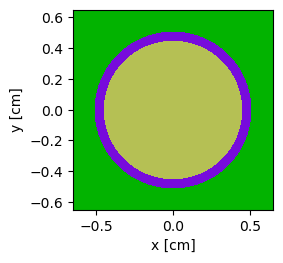

In [7]:
geometry.root_universe.plot()

In [8]:
settings = openmc.Settings()
settings.particles = 10000
settings.inactive = 10
settings.batches = 50

In [9]:
fuel.volume = math.pi * radii[0] ** 2
clad.volume = math.pi * (radii[1]-radii[0]) ** 2

In [10]:
chain = openmc.deplete.Chain.from_xml("chain_endfb80_sfr.xml")
chain.nuclide_dict

{'H1': 0,
 'H2': 1,
 'H3': 2,
 'H4': 3,
 'H5': 4,
 'H6': 5,
 'H7': 6,
 'He3': 7,
 'He4': 8,
 'He5': 9,
 'He6': 10,
 'He7': 11,
 'He8': 12,
 'He9': 13,
 'He10': 14,
 'Li4': 15,
 'Li5': 16,
 'Li6': 17,
 'Li7': 18,
 'Li8': 19,
 'Li9': 20,
 'Li10': 21,
 'Li11': 22,
 'Li12': 23,
 'Be5': 24,
 'Be6': 25,
 'Be7': 26,
 'Be8': 27,
 'Be9': 28,
 'Be10': 29,
 'Be11': 30,
 'Be12': 31,
 'Be13': 32,
 'Be14': 33,
 'Be15': 34,
 'Be16': 35,
 'B6': 36,
 'B7': 37,
 'B8': 38,
 'B9': 39,
 'B10': 40,
 'B11': 41,
 'B12': 42,
 'B13': 43,
 'B14': 44,
 'B15': 45,
 'B16': 46,
 'B17': 47,
 'B18': 48,
 'B19': 49,
 'C8': 50,
 'C9': 51,
 'C10': 52,
 'C11': 53,
 'C12': 54,
 'C13': 55,
 'C14': 56,
 'C15': 57,
 'C16': 58,
 'C17': 59,
 'C18': 60,
 'C19': 61,
 'C20': 62,
 'C21': 63,
 'C22': 64,
 'N10': 65,
 'N11': 66,
 'N12': 67,
 'N13': 68,
 'N14': 69,
 'N15': 70,
 'N16': 71,
 'N17': 72,
 'N18': 73,
 'N19': 74,
 'N20': 75,
 'N21': 76,
 'N22': 77,
 'N23': 78,
 'N24': 79,
 'N25': 80,
 'O12': 81,
 'O13': 82,
 'O14': 83,
 'O1

In [11]:
model = openmc.Model(geometry=geometry, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "chain_endfb80_sfr.xml")

In [12]:
power = 210

In [13]:
time_steps = [30] * 6

In [14]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [15]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Al27 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Al27.h5
 Reading P31 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/P31.h5
 Reading S32 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S32.h5
 Reading S33 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S33.h5
 Reading S34 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S34.h5
 Reading S36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S36.h5
 Reading Cl35 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl35.h5
 Reading Cl37 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl37.h5
 Reading Ar36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar36.h5
 Reading Ar38 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar38.h5
 Reading Ar40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar40.h5
 Reading K39 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K39.h5
 Reading K40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K40.h5


 Reading K41 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K41.h5
 Reading Ca40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca40.h5
 Reading Ca42 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca42.h5
 Reading Ca43 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca43.h5
 Reading Ca44 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca44.h5
 Reading Ca46 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca46.h5
 Reading Ca48 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca48.h5
 Reading Sc45 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sc45.h5
 Reading V50 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V50.h5
 Reading V51 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V51.h5
 Reading Fe54 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fe54.h5
 Reading Fe56 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fe56.h5
 Reading Fe57 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fe57.h5
 Reading Fe58 from /home/orion/Downloads/end

 Reading Kr80 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr80.h5
 Reading Kr82 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr82.h5
 Reading Kr83 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr83.h5
 Reading Kr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr84.h5
 Reading Kr85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr85.h5
 Reading Kr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr86.h5
 Reading Rb85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb85.h5
 Reading Rb86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb86.h5
 Reading Rb87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb87.h5
 Reading Sr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr84.h5
 Reading Sr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr86.h5
 Reading Sr87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr87.h5
 Reading Sr88 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr88.h5
 Reading Sr89 from /home/orion/Downloa

 Reading Ru96 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru96.h5
 Reading Ru98 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru98.h5
 Reading Ru99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru99.h5
 Reading Ru100 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru100.h5
 Reading Ru101 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru101.h5
 Reading Ru102 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru102.h5
 Reading Ru103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru103.h5
 Reading Ru104 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru104.h5
 Reading Ru105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru105.h5
 Reading Ru106 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru106.h5
 Reading Rh103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rh103.h5
 Reading Rh105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rh105.h5
 Reading Pd102 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Pd102.h5
 Reading Pd104 fro

          1200K
          2500K


 Reading Cd108 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd108.h5
 Reading Cd110 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd110.h5
 Reading Cd111 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd111.h5
 Reading Cd112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd112.h5
 Reading Cd113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd113.h5
 Reading Cd114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd116.h5
 Reading In113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In113.h5
 Reading In115 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In115.h5
 Reading Sn112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn112.h5
 Reading Sn113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn113.h5
 Reading Sn114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn114.h5
 Read

          1200K
          2500K
          1200K
          2500K


 Reading Sn125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn125.h5
 Reading Sn126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn126.h5
 Reading Sb121 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb121.h5
 Reading Sb123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb123.h5
 Reading Sb124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb124.h5
 Reading Sb125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb125.h5
 Reading Sb126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb126.h5
 Reading Te120 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te120.h5
 Reading Te122 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te122.h5
 Reading Te123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te123.h5
 Reading Te124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te124.h5
 Reading Te125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te125.h5
 Reading Te126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te126.h5
 Reading Te1

 Reading Xe126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe126.h5
 Reading Xe128 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe128.h5
 Reading Xe129 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe129.h5
 Reading Xe130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe130.h5
 Reading Xe131 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe131.h5
 Reading Xe132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe132.h5
 Reading Xe133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe134.h5
 Reading Xe135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe135.h5
 Reading Xe136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe136.h5
 Reading Cs133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs133.h5
 Reading Cs134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs134.h5
 Reading Cs135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs135.h5
 Reading Cs136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs136.h5
 Reading Cs137 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs137.h5
 Reading Ba130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba130.h5
 Reading Ba132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba132.h5
 Reading Ba133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba133.h5
 Reading Ba134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba134.h5
 Reading Ba135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba135.h5
 Reading Ba1

          1200K
          2500K


 Reading Gd153 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd153.h5
 Reading Gd154 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd154.h5
 Reading Gd155 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd155.h5
 Reading Gd156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd156.h5
 Reading Gd157 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd157.h5
 Reading Gd158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd158.h5
 Reading Gd160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd160.h5
 Reading Tb159 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb159.h5
 Reading Tb160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb160.h5
 Reading Dy156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy156.h5
 Reading Dy158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy158.h5
 Reading Dy160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy160.h5
 Reading Dy161 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy161.h5
 Reading Dy1

          1200K


 Reading Es252 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es252.h5
 Reading Es253 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es253.h5
 Reading Es254 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254.h5
 Reading Es254_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254_m1.h5
 Reading Es255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es255.h5
 Reading Fm255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fm255.h5
 Maximum neutron transport energy: 8100000 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.28344
        2/1    2.30594
        3/1    2.30685
        4/1    2.28316
        5/1    2.27419
        6/1    2.30420
        7/1    2.30778
        8/1    2.29486
        9/1    2.31424
       10/1    2.33111
       11/1    2.27943
       12/1    2.31891    2.299

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.26460
        2/1    2.28662
        3/1    2.27437
        4/1    2.30177
        5/1    2.31405
        6/1    2.28575
        7/1    2.27476
        8/1    2.27978
        9/1    2.29899
       10/1    2.27554
       11/1    2.30624
       12/1    2.27324    2.28974 +/- 0.01650
       13/1    2.28027    2.28658 +/- 0.01003
       14/1    2.30750    2.29181 +/- 0.00881
       15/1    2.28851    2.29115 +/- 0.00686
       16/1    2.29161    2.29123 +/- 0.00560
       17/1    2.30425    2.29309 +/- 0.00509
       18/1    2.29083    2.29281 +/- 0.00441
       19/1    2.29182    2.29270 +/- 0.00389
       20/1    2.29321    2.29275 +/- 0.00348
       21/1    2.32544    2.29572 +/- 0.00433
       22/1    2.27325    2.29385 +/- 0.00437
       23/1    2.29227    2.29373 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.31532
        2/1    2.31916
        3/1    2.27546
        4/1    2.29211
        5/1    2.28806
        6/1    2.28473
        7/1    2.27460
        8/1    2.29442
        9/1    2.27510
       10/1    2.29111
       11/1    2.31582
       12/1    2.26826    2.29204 +/- 0.02378
       13/1    2.27591    2.28666 +/- 0.01474
       14/1    2.28190    2.28547 +/- 0.01049
       15/1    2.28990    2.28636 +/- 0.00818
       16/1    2.27180    2.28393 +/- 0.00710
       17/1    2.30661    2.28717 +/- 0.00682
       18/1    2.26518    2.28442 +/- 0.00652
       19/1    2.30071    2.28623 +/- 0.00603
       20/1    2.31327    2.28893 +/- 0.00603
       21/1    2.30224    2.29014 +/- 0.00559
       22/1    2.31045    2.29184 +/- 0.00537
       23/1    2.29660    2.29220 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.32204
        2/1    2.30866
        3/1    2.30080
        4/1    2.31451
        5/1    2.26801
        6/1    2.26576
        7/1    2.28064
        8/1    2.27967
        9/1    2.28822
       10/1    2.29616
       11/1    2.30285
       12/1    2.29154    2.29720 +/- 0.00565
       13/1    2.27891    2.29110 +/- 0.00691
       14/1    2.26532    2.28465 +/- 0.00809
       15/1    2.26456    2.28064 +/- 0.00744
       16/1    2.31192    2.28585 +/- 0.00801
       17/1    2.27554    2.28438 +/- 0.00693
       18/1    2.29806    2.28609 +/- 0.00624
       19/1    2.30708    2.28842 +/- 0.00598
       20/1    2.27292    2.28687 +/- 0.00556
       21/1    2.28598    2.28679 +/- 0.00503
       22/1    2.31346    2.28901 +/- 0.00510
       23/1    2.32704    2.29194 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.25135
        2/1    2.30982
        3/1    2.31975
        4/1    2.29003
        5/1    2.28919
        6/1    2.28604
        7/1    2.27852
        8/1    2.27438
        9/1    2.31036
       10/1    2.26742
       11/1    2.27957
       12/1    2.30342    2.29149 +/- 0.01192
       13/1    2.27261    2.28520 +/- 0.00933
       14/1    2.30741    2.29075 +/- 0.00862
       15/1    2.24030    2.28066 +/- 0.01210
       16/1    2.32321    2.28775 +/- 0.01216
       17/1    2.30773    2.29061 +/- 0.01067
       18/1    2.30192    2.29202 +/- 0.00935
       19/1    2.27616    2.29026 +/- 0.00843
       20/1    2.31768    2.29300 +/- 0.00802
       21/1    2.29582    2.29326 +/- 0.00726
       22/1    2.28230    2.29234 +/- 0.00669
       23/1    2.27435    2.29096 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.27880
        2/1    2.30527
        3/1    2.26483
        4/1    2.30896
        5/1    2.26600
        6/1    2.33559
        7/1    2.29973
        8/1    2.29979
        9/1    2.29928
       10/1    2.29255
       11/1    2.27771
       12/1    2.27813    2.27792 +/- 0.00021
       13/1    2.31774    2.29120 +/- 0.01327
       14/1    2.31929    2.29822 +/- 0.01172
       15/1    2.28425    2.29543 +/- 0.00950
       16/1    2.31220    2.29822 +/- 0.00825
       17/1    2.30382    2.29902 +/- 0.00701
       18/1    2.28479    2.29724 +/- 0.00633
       19/1    2.27572    2.29485 +/- 0.00607
       20/1    2.30983    2.29635 +/- 0.00563
       21/1    2.27258    2.29419 +/- 0.00554
       22/1    2.26832    2.29203 +/- 0.00549
       23/1    2.26015    2.28958 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.27174
        2/1    2.25361
        3/1    2.30847
        4/1    2.29467
        5/1    2.29476
        6/1    2.25909
        7/1    2.29256
        8/1    2.32161
        9/1    2.30670
       10/1    2.28403
       11/1    2.26419
       12/1    2.26618    2.26518 +/- 0.00100
       13/1    2.27676    2.26904 +/- 0.00390
       14/1    2.24697    2.26353 +/- 0.00617
       15/1    2.29001    2.26882 +/- 0.00714
       16/1    2.27237    2.26941 +/- 0.00586
       17/1    2.27475    2.27018 +/- 0.00501
       18/1    2.26250    2.26922 +/- 0.00444
       19/1    2.24176    2.26617 +/- 0.00496
       20/1    2.29359    2.26891 +/- 0.00522
       21/1    2.31225    2.27285 +/- 0.00615
       22/1    2.26882    2.27251 +/- 0.00562
       23/1    2.28590    2.27354 +/- 0.00

In [16]:
results = openmc.deplete.Results("./depletion_results.h5")

In [17]:
time, k = results.get_keff()

In [18]:
time /= (24 * 60 * 60)  # convert back to days from seconds

In [19]:
k

array([[2.29805810e+00, 1.24954127e-03],
       [2.29616491e+00, 1.32246809e-03],
       [2.29236316e+00, 1.18012277e-03],
       [2.29214850e+00, 1.10659207e-03],
       [2.28939989e+00, 1.33809782e-03],
       [2.28713998e+00, 1.28182319e-03],
       [2.28382990e+00, 1.24825251e-03]])

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2704/3379722013.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$k_{eff}\pm \sigma$");


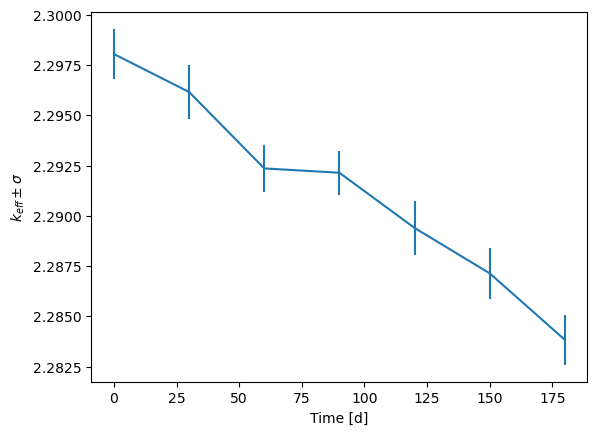

In [20]:
plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel("Time [d]")
plt.ylabel("$k_{eff}\pm \sigma$");

+ Il materiale Cladding ha numero identificativo $ID:2$
+ Il materiale Fuel ha numero identificativo $ID:1$

In [21]:
_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_,he4=results.get_atoms("2","He4")
_,ni58=results.get_atoms("2","Ni58")
_,ni59=results.get_atoms("2","Ni59")
_,Fe56=results.get_atoms("2","Fe56")
_,u235=results.get_atoms("1","U235")
_,u238=results.get_atoms("1","U238")
_,pu239=results.get_atoms("1","Pu239")
_,pu238=results.get_atoms("1","Pu238")

In [22]:
"""plt.plot(time, he4, label="He4")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - He4");"""

'plt.plot(time, he4, label="He4")\nplt.xlabel("Time [d]")\nplt.ylabel("Number of atoms - He4");'

In [23]:
max_he4=np.max(he4)
print(f"Max He4: {max_he4:.3e}")

Max He4: 3.566e+16


la quantita di He generata nel cladding è riferita ad un ciclidro coassiale di lunghezza $1[cm]$ quindi dato che la lunghezza totale di un fuel rod (non lunghezza attiva) in cui si possono formare atomi di $He$ è lunga $1\cdot 10^2 [cm]$ allora questo valore va moliplicato per $100$, ovvero $1.713\cdot 10^{18}$

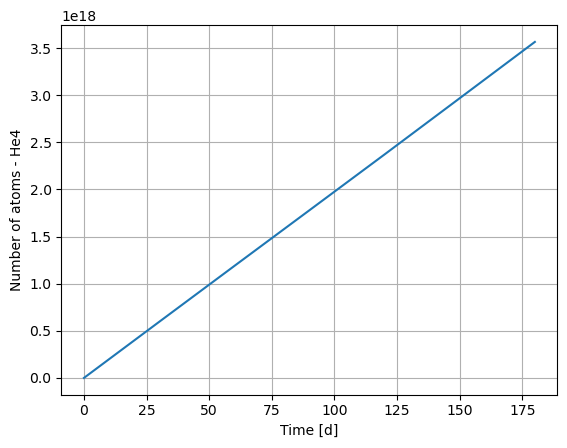

In [24]:
plt.plot(time, he4*100, label="He4")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - He4");
plt.grid()

TO DO: passare in ppm il quantitativo di He4

"axs[3, 0].plot(t, YH[:,3])\naxs[3, 0].set_title('Coolant temperature (°C)')\naxs[3, 0].grid()\naxs[4, 0].plot(t, YH[:,4],)\naxs[4, 0].set_title('Coolant outlet temperature (°C)')\naxs[4, 0].grid()\naxs[5, 0].plot(t, YH[:,5]*10**5, )\naxs[5, 0].set_title('Total reactivity (pcm)')\naxs[5, 0].grid()"

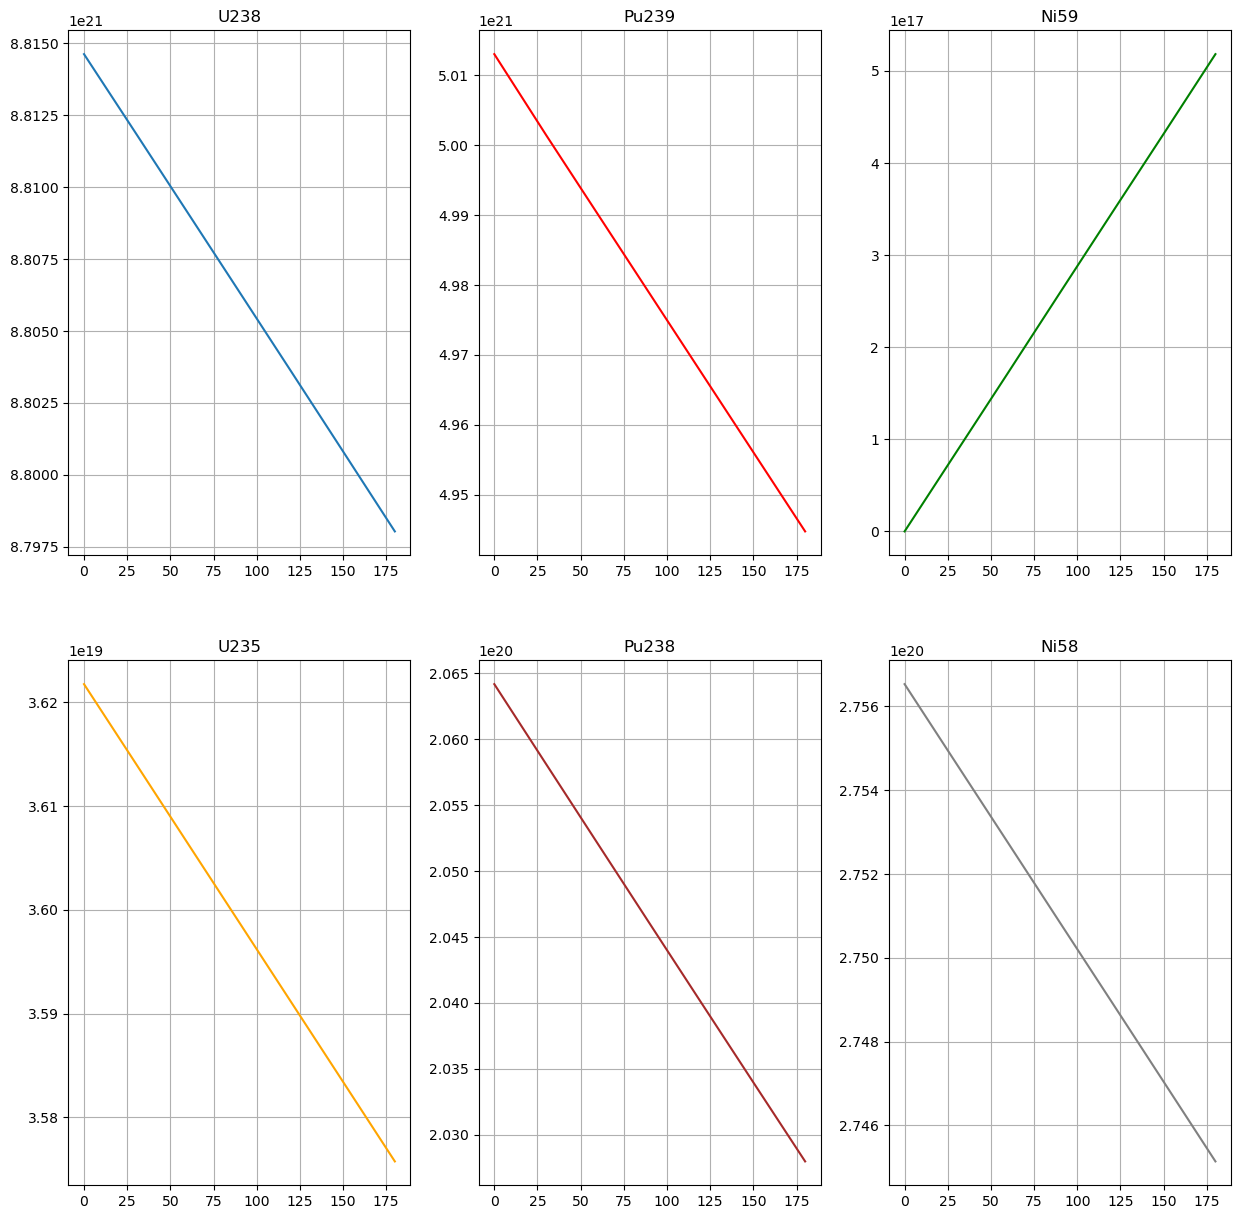

In [25]:
fig, axs = plt.subplots(2, 3,figsize=(15, 15))
axs[0, 0].plot(time, u238)
axs[0, 0].set_title('U238')
axs[0, 0].grid()
axs[0, 1].plot(time, pu239,color='red')
axs[0, 1].set_title('Pu239')
axs[0, 1].grid()
axs[1, 1].plot(time, pu238,color='brown')
axs[1, 1].set_title('Pu238')
axs[1, 1].grid()
axs[1, 0].plot(time, u235,color='orange')
axs[1, 0].set_title('U235')
axs[1, 0].grid()
axs[0, 2].plot(time, ni59,color='green')
axs[0, 2].set_title('Ni59')
axs[0, 2].grid()
axs[1, 2].plot(time, ni58,color='gray')
axs[1, 2].set_title('Ni58')
axs[1, 2].grid()
"""axs[3, 0].plot(t, YH[:,3])
axs[3, 0].set_title('Coolant temperature (°C)')
axs[3, 0].grid()
axs[4, 0].plot(t, YH[:,4],)
axs[4, 0].set_title('Coolant outlet temperature (°C)')
axs[4, 0].grid()
axs[5, 0].plot(t, YH[:,5]*10**5, )
axs[5, 0].set_title('Total reactivity (pcm)')
axs[5, 0].grid()"""

# Tallies

In [26]:
# Neutron spectrum
tally_list = []

n_groups = 500
Emin = 1e-5
Emax = 20e6

energies = np.logspace(log10(Emin), log10(Emax), n_groups+1)

energy_filter = openmc.EnergyFilter(energies)

spectrum = openmc.Tally(name = "Neutron Spectrum")
spectrum.filters = [energy_filter]
spectrum.scores = ['flux']


#Tally DPA
cell_filter = openmc.CellFilter(root_cell)
dpa_reaction_tally = openmc.Tally(name='DPA')
dpa_reaction_tally.filters = [cell_filter]
dpa_reaction_tally.scores = ['444']  # note use of 444 in string format, this is the MT reaction number for damage energy more MT numbers here https://t2.lanl.gov/nis/endf/mts.html


dpa_reaction_tally.nuclides = ['Cr50','Cr52','Cr53','Cr54','Ni58','Ni60','Ni61','Ni62',
                               'Ni64','Mo92','Mo94','Mo95','Mo96','Mo97','Mo98','Mo100'
                               ,'Mg24','Mg25','Mg26','Si28','Si29','Si30','Ti46','Ti47'
                               ,'Ti48','Ti49','Ti50','C0'] # C0 è il carbonio C12
#my_tallies = openmc.Tallies([dpa_reaction_tally])


tally_list.append(spectrum)
tally_list.append(dpa_reaction_tally)

In [27]:
tallies = openmc.Tallies(tally_list)
tallies.export_to_xml()

In [28]:
openmc.run()

[Matteo-Device:13383] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/2295660544/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:13383] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%

In [29]:
sp = openmc.StatePoint('statepoint.50.h5')

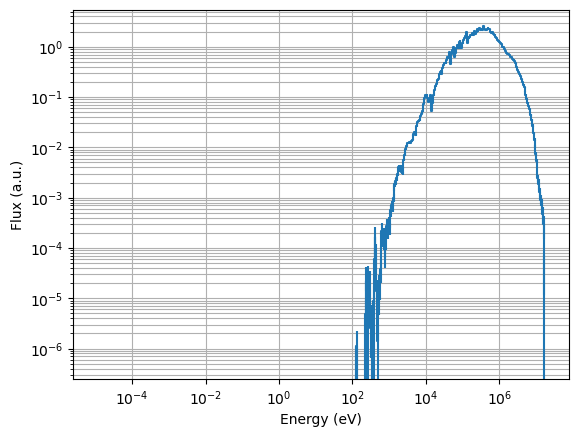

In [30]:
# Neutron spectrum
spectrum_tally = sp.get_tally(name = "Neutron Spectrum")

e_filter = spectrum_tally.filters[0]
E = e_filter.bins[:,0]

spectrum_mean = spectrum_tally.get_values(value = 'mean').ravel()
spectrum_std_dev = spectrum_tally.get_values(value = 'std_dev').ravel()

# Plot
fig, ax = plt.subplots()
plt.errorbar(E, spectrum_mean,spectrum_std_dev, ds = 'steps')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Flux (a.u.)")
ax.grid(True, which = 'both')
#plt.savefig('./energy_flux.pdf', format='pdf', dpi = 600, bbox_inches = 'tight')

In [31]:
np.argmax(spectrum_mean)
print(f"{E[434]:3e}")

4.756572e+05


Il flusso è in unità arbitrarie (a.u), va normalizzato:
+ La potenza del reattore ALFRED è $300[MW]$
+ lo spettro energetico del flusso neutronico è di energia media $1MeV=1.602\cdot 10^{-13}[Joule]$
+ OpenMC esprime le quantità moltiplicate per unità di lunghezza peranta si deve normalizzare il flusso neutronico in base all'energia e al volume della cella in modo tale da avere in flusso $\phi\bigg[\frac{\#}{cm^2 \cdot s}\bigg]$
+ Il volume della cella è $V=2.6^2\cdot 1=6.76[cm^3]$
+ Si calcola $\phi=\frac{300[MW]}{1.602\cdot 10^{-13}[Joule]}\bigg[\frac{\#\cdot cm}{s}\bigg]\implies \phi_{norm}=\frac{300[MW]}{1.602\cdot 10^{-13}[Joule]\cdot V}\bigg[\frac{\#}{cm^2s}\bigg]=2.77\cdot 10^{14}\bigg[\frac{\#}{cm^2s}\bigg]$

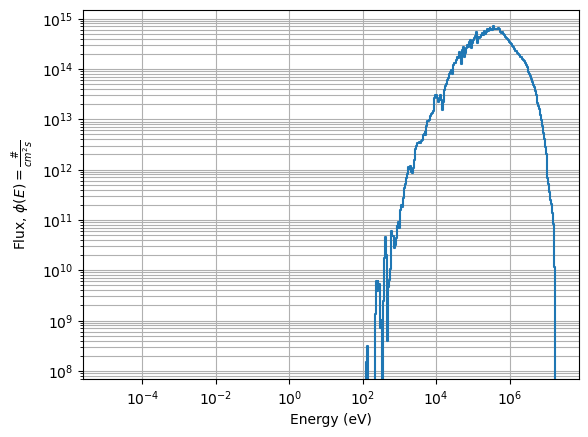

In [32]:
# Neutron spectrum
spectrum_tally = sp.get_tally(name = "Neutron Spectrum")

e_filter = spectrum_tally.filters[0]
E = e_filter.bins[:,0]

spectrum_mean = spectrum_tally.get_values(value = 'mean').ravel()
spectrum_std_dev = spectrum_tally.get_values(value = 'std_dev').ravel()

# Plot
fig, ax = plt.subplots()
plt.errorbar(E, spectrum_mean*2.77*10**(14),spectrum_std_dev, ds = 'steps')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel(r"Flux, $\phi(E)=\frac{\#}{cm^2s}$")
ax.grid(True, which = 'both')

In [33]:
print(np.max(spectrum_mean))

2.5310783653067053


### DPA

In [34]:
dpa_tally=sp.get_tally(name='DPA')
df = dpa_tally.get_pandas_dataframe()

print(df)

    cell nuclide          score     mean  std. dev.
0      4    Cr50  damage-energy 9.01e+02   1.31e+00
1      4    Cr52  damage-energy 1.48e+04   2.14e+01
2      4    Cr53  damage-energy 2.10e+03   3.02e+00
3      4    Cr54  damage-energy 4.19e+02   5.84e-01
4      4    Ni58  damage-energy 1.26e+04   1.93e+01
5      4    Ni60  damage-energy 4.32e+03   6.35e+00
6      4    Ni61  damage-energy 2.00e+02   2.89e-01
7      4    Ni62  damage-energy 6.68e+02   1.08e+00
8      4    Ni64  damage-energy 1.75e+02   2.77e-01
9      4    Mo92  damage-energy 1.68e+02   2.58e-01
10     4    Mo94  damage-energy 1.02e+02   1.57e-01
11     4    Mo95  damage-energy 1.67e+02   2.62e-01
12     4    Mo96  damage-energy 1.80e+02   2.79e-01
13     4    Mo97  damage-energy 1.00e+02   1.56e-01
14     4    Mo98  damage-energy 2.57e+02   3.98e-01
15     4   Mo100  damage-energy 9.82e+01   1.53e-01
16     4    Mg24  damage-energy 0.00e+00   0.00e+00
17     4    Mg25  damage-energy 0.00e+00   0.00e+00
18     4    

In [35]:
damage_energy_in_ev = df['mean'].sum() #T_D in NRT equation
E_D = 40 # threshold displacement energy of Fe in eV

print('Damage energy deposited per source neutron = ', f"{damage_energy_in_ev:.2f}", 'eV\n')

print('Two times the threshold energy of 40eV is needed to displace an atom')
displacements_per_source_neutron = 0.8*damage_energy_in_ev / (2*E_D)
print('(NRT) Displacements per source neutron = ', f"{displacements_per_source_neutron:.2f}", '\n')

Damage energy deposited per source neutron =  41477.58 eV

Two times the threshold energy of 40eV is needed to displace an atom
(NRT) Displacements per source neutron =  414.78 



In [36]:
fusion_power = 3e6  # units Watts
energy_per_fusion_reaction = 2e6  # units eV
eV_to_Joules = 1.60218e-19  # multiplication factor to convert eV to Joules
number_of_neutrons_per_second = 6*10**(13) #fluenza*Area_fuel= neutroni/s
print('Number of neutrons per second', f"{number_of_neutrons_per_second:.2e}", '\n')

number_of_neutrons_per_year = number_of_neutrons_per_second * 60 * 60 * 24 * 365.25
print('Number of neutrons per full power year ', f"{number_of_neutrons_per_year:.2e}")

displacements_for_all_atoms = number_of_neutrons_per_year * displacements_per_source_neutron
print('(NRT) Displacements for all atoms in the volume ', f"{displacements_for_all_atoms:.2e}", '\n')

print('Now the number of atoms in the volume must be found to find displacements per atom (DPA)')

volume_of_firstwall_cell = fuel.volume+clad.volume  

iron_atomic_mass_in_g = 100*1.66054E-24  #(g) # molar mass multiplier by the atomic mass unit (u)
number_of_iron_atoms = volume_of_firstwall_cell * 5 / (iron_atomic_mass_in_g)

print('Number of iron atoms in the firstwall ', f"{number_of_iron_atoms:.2e}")

Number of neutrons per second 6.00e+13 

Number of neutrons per full power year  1.89e+21
(NRT) Displacements for all atoms in the volume  7.85e+23 

Now the number of atoms in the volume must be found to find displacements per atom (DPA)
Number of iron atoms in the firstwall  1.95e+22


In [37]:
DPA_NRT = displacements_for_all_atoms / number_of_iron_atoms

print('NRT-DPA =', f"{DPA_NRT:.2f}")

NRT-DPA = 40.28
